
## Jupyter notebook to generate the data and plot Figure 1 in "Heat extremes driven by amplification of phase-locked circumglobal waves forced by topography in an idealized atmospheric model" by B. Jimenez-Esteve, K. Kornhuber and D. I.V. Domeisen

Author: Bernat Jimenez-Esteve (ETH Zurich) 
Last update: September 2022 

The blocks need to be executed sequencially in order to be able to reproduce the same Figure as in the paper. 

The netCDF files containing the processed model data can be downloaded from the following repository:


In [3]:
#load main modeules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Load the necessary data

In [4]:
# the user would need to adapt this directory here:
root='data/wave_amplitudes/'
amp_0 = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_notopo.nc').amplitudes

wn, time = amp_0.wavenumber, amp_0.time
amp_mnt = xr.DataArray(coords=[[0,1,2,3],time, wn], dims=['sim','time','wn'])
phase_mnt = xr.DataArray(coords=[[0,1,2,3],time, wn], dims=['sim','time','wn'])

In [7]:
amp_mnt[0] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_notopo.nc').amplitudes
amp_mnt[1] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_4km_45N.nc').amplitudes
amp_mnt[2] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_8km_45N.nc').amplitudes
amp_mnt[3] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_8km_25N.nc').amplitudes

phase_mnt[0] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_notopo.nc').phases
phase_mnt[1] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_4km_45N.nc').phases
phase_mnt[2] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_8km_45N.nc').phases
phase_mnt[3] = xr.open_dataset(root+'wave_amp_phase_v300_60-30N_7d_mean_ICON_heldsuarez_topo_8km_25N.nc').phases

# Amplitude vs Phase plot

Calculation of the phase-locking index: "Minimum width which contains half of the probability density"

In [8]:
#calculation of the phase locking index (delta_min)

delta_min = np.empty((4,5))

n1 = 100  #number of divisisions (delta_pi = 2pi/n)
xedges = np.linspace(-np.pi,np.pi,n1+1)

def prob_max(delta, n1, hist_pad):
    'calculates the maximum probability given a a window lenght'
    probs = np.zeros(hist_pad.size-delta)
    for i in np.arange(0, hist_pad.size-delta):
        probs[i] =  np.sum(hist_pad[(i):(i+delta-1)])
        
    max_prob = np.max(probs)
    max_index = np.argmax(probs)
    return max_prob, max_index

def cal_minimum_window(hist_pad, delta, n1):
    while (prob_max(delta, n1, hist_pad)[0] > 0.5):
        delta = delta - 1
    return delta

for sim in [0,1,2,3]:
    for i,wn in enumerate([4,5,6,7,8]):
        hist = np.histogram(phase_mnt[sim,:,wn],bins=xedges, density=False)
        hist_norm = hist[0]/len(phase_mnt[sim,:,wn])
        hist_pad = np.pad(hist_norm, int(n1/2), 'wrap')
        delta_0= int(n1/2) + 1
        delta_min[sim,i] = cal_minimum_window(hist_pad, delta_0, n1)/n1*2*np.pi

delta_min

array([[3.0787608 , 2.82743339, 3.14159265, 3.0787608 , 3.01592895],
       [2.70176968, 2.57610598, 2.51327412, 2.63893783, 2.76460154],
       [1.50796447, 1.57079633, 1.44513262, 2.76460154, 2.0106193 ],
       [2.0106193 , 1.88495559, 2.0106193 , 2.63893783, 2.38761042]])

### For sumplentary Figure S3, we calculate the uncertanty in the phase-locking index using block bootsrapping

In [9]:
#calculate uncertainty in the delta_min value using blocks of a certain lenght
#this can take a while depending on the number of repetitions we choose

repetitions = 1000
n1 = 100  #number of divisisions (delta_pi = 2pi/n)
delta_min_sample = np.empty((4,5,repetitions))
block = 10
sample_size = phase_mnt[0,:,0].size
n_blocks = sample_size//block

for rep in range(0,repetitions):
    n = np.random.randint(0, sample_size-block, size=n_blocks)
    for i in np.arange(0, block-1):
        n = np.append(n,n[i*n_blocks::]+1)
        
    for sim in [0,1,2,3]:
        for i,wn in enumerate([4,5,6,7,8]):
            hist = np.histogram(phase_mnt[sim,n,wn],bins=xedges, density=False)
            hist_norm = hist[0]/len(phase_mnt[sim,n,wn])
            hist_pad = np.pad(hist_norm, int(n1/2), 'wrap')
            delta_0= int(n1/2) + 1
            delta_min_sample[sim,i,rep] = cal_minimum_window(hist_pad, delta_0, n1)/n1*2*np.pi       

In [10]:
# based on the distribution created above we can here calculate the min and max of the distribution, 
# can be changed to different percentiles if needed

delta_min_errorbars = np.empty((2,4,5))
errors = np.empty((2,4,5))
for sim in [0,1,2,3]:
    for i,wn in enumerate([4,5,6,7,8]):
        delta_min_errorbars[0,sim,i] = np.percentile(delta_min_sample[sim,i,:],0)
        delta_min_errorbars[1,sim,i] = np.percentile(delta_min_sample[sim,i,:],100)
     
errors[0,:,:] = -1*(delta_min_errorbars[0,:,:] - delta_min[:,:]) #this needs to be negative for the plotting below
errors[1,:,:] = (delta_min_errorbars[1,:,:] - delta_min[:,:])

#### We need to calculate the same delta_m but now only for high amplitude events

In [11]:
# We need to calculate the same delta_m but now only for high amplitude events

delta_min_highamp = np.empty((4,5))

n1 = 100  #number of divisisions (delta_pi = 2pi/n)
xedges = np.linspace(-np.pi,np.pi,n1 +1)
thresh = amp_mnt.mean('time')+1.5*amp_mnt.std('time')

for sim in [0,1,2,3]:
    for i,wn in enumerate([4,5,6,7,8]):
        i_high_amp = np.array(np.where(amp_mnt[sim,:,wn]>thresh[sim,wn])).flatten()
        hist = np.histogram(phase_mnt[sim,i_high_amp,wn],bins=xedges, density=False)
        hist_norm = hist[0]/len(phase_mnt[sim,i_high_amp,wn])
        hist_pad = np.pad(hist_norm, int(n1/2), 'wrap')
        delta_0= int(n1/2) + 1
        delta_min_highamp[sim,i] = cal_minimum_window(hist_pad, delta_0, n1)/n1*2*np.pi

delta_min

array([[3.0787608 , 2.82743339, 3.14159265, 3.0787608 , 3.01592895],
       [2.70176968, 2.57610598, 2.51327412, 2.63893783, 2.76460154],
       [1.50796447, 1.57079633, 1.44513262, 2.76460154, 2.0106193 ],
       [2.0106193 , 1.88495559, 2.0106193 , 2.63893783, 2.38761042]])

### PLOTTING OF FIGURE S3

<ipython-input-16-f4a3fe84ba12>:27: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.bar(n_bins, delta_min_highamp[0,:], width=0.2, color='', linewidth= 2.0, edgecolor='k', align='edge')
<ipython-input-16-f4a3fe84ba12>:29: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.bar(n_bins, delta_min_highamp[1,:], width=0.2, color='', linewidth= 2.0, edgecolor='k', align='edge')
<ipython-input-16-f4a3fe84ba12>:31: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.bar(n_bins, delta_min_highamp[2,:], width=0.2, color='', linewidth= 2.0, edgecolor='k', align=

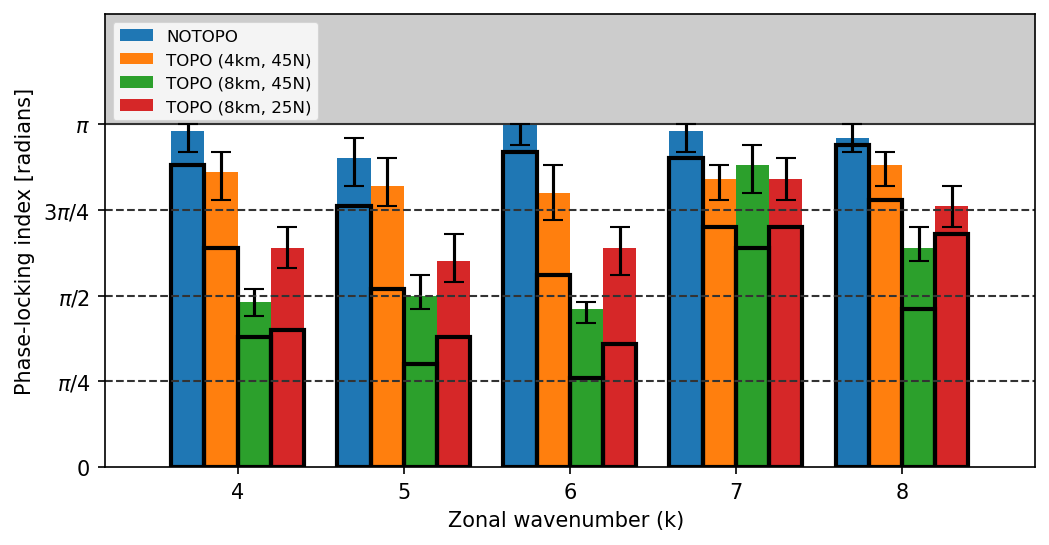

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = 8,4

#Histograms
f, ax = plt.subplots(1,1, sharex=True)

colors = ['0.6', 'C0', 'C1','C2']

### HERE WE PLOT THE BARS
n_bins= np.arange(3.6,8.6,1.0)
plt.bar(n_bins, delta_min[0,:], yerr=errors[:,0,:], width=0.2, 
                                ecolor='black', capsize=5, align='edge', label = 'NOTOPO')
n_bins= np.arange(3.8,8.7,1.0)
plt.bar(n_bins, delta_min[1,:], yerr=errors[:,1,:], width=0.2, 
                                ecolor='black', capsize=5, align='edge', label = 'TOPO (4km, 45N)')
n_bins= np.arange(4.0,9.0,1.0)
plt.bar(n_bins, delta_min[2,:], yerr=errors[:,2,:], width=0.2, 
                                ecolor='black', capsize=5, align='edge', label = 'TOPO (8km, 45N)')
n_bins= np.arange(4.2,9.2,1.0)
plt.bar(n_bins, delta_min[3,:], yerr=errors[:,3,:], width=0.2, 
                                ecolor='black', capsize=5, align='edge', label = 'TOPO (8km, 25N)')
    
n_bins= np.arange(3.6,8.6,1.0)
plt.bar(n_bins, delta_min_highamp[0,:], width=0.2, color='', linewidth= 2.0, edgecolor='k', align='edge')
n_bins= np.arange(3.8,8.7,1.0)
plt.bar(n_bins, delta_min_highamp[1,:], width=0.2, color='', linewidth= 2.0, edgecolor='k', align='edge')
n_bins= np.arange(4.0,9.0,1.0)
plt.bar(n_bins, delta_min_highamp[2,:], width=0.2, color='', linewidth= 2.0, edgecolor='k', align='edge')
n_bins= np.arange(4.2,9.2,1.0)
plt.bar(n_bins, delta_min_highamp[3,:], width=0.2, color='', linewidth= 2.0, edgecolor='k', align='edge')

ax.axhline(np.pi, color='0.2', ls='-',lw=1.0, zorder= 1)
ax.axhline(np.pi/2, color='0.2', ls='--',lw=1.0)
ax.axhline(np.pi*0.75, color='0.2', ls='--',lw=1.0)
ax.axhline(np.pi*0.25, color='0.2', ls='--',lw=1.0)
#set plot limits
ax.set_xlim(3.2,8.8)
ax.set_ylim(0.0,4.15)
ax.set_xticks([4,5,6,7,8])

ax.fill_between([0,10], 3.1416, 4.6, color='0.8', zorder= 0)

ax.set_yticks(np.arange(0,np.pi+0.01,np.pi/4))
labels = ['0','$\pi/4$', '$\pi/2$','$3\pi/4$','$\pi$']
ax.set_yticklabels(labels)

#adding a legend
ax.legend(fontsize=8,loc='upper left')

#ax.set_title('zonal wavenumber k='+str(k))
ax.set_ylabel('Phase-locking index [radians]')
ax.set_xlabel('Zonal wavenumber (k) ')

plt.savefig('figures/phase_locking_index_different_sim_uncertainty_and_1p5SD.pdf',bbox_inches='tight')
plt.show()

plt.close()

# Calculation of the 2D-HISTOGRAMS (Amplitude vs. Phase) for Figure 1

In [17]:
n1 = 100 #number of divisisions (delta_pi = 2pi/n)
phase_max = np.empty((4,5))
xedges = np.linspace(-np.pi,np.pi,n1)

for sim in [0,1,2,3]:
    for i,wn in enumerate([4,5,6,7,8]):
        #i_high_amp = np.array(np.where(amp_mnt[sim,:,wn]>thresh[sim,wn])).flatten()
        hist = np.histogram(phase_mnt[sim,:,wn],bins=xedges, density=False)
        hist_norm = hist[0]/len(phase_mnt[sim,i_high_amp,wn])
        phase_max[sim,i] = hist[1][np.argmax(hist_norm)]

In [18]:
def histogram_2d(phase, amplitude ,n1,n2):
    
    xedges = np.linspace(-np.pi,np.pi,n1)
    yedges = np.linspace(0,20,n2)
    H, xedges, yedges = np.histogram2d(phase, amplitude, bins=(xedges, yedges), density=True)
    
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2

    return H,xedges,yedges,xcenters,ycenters

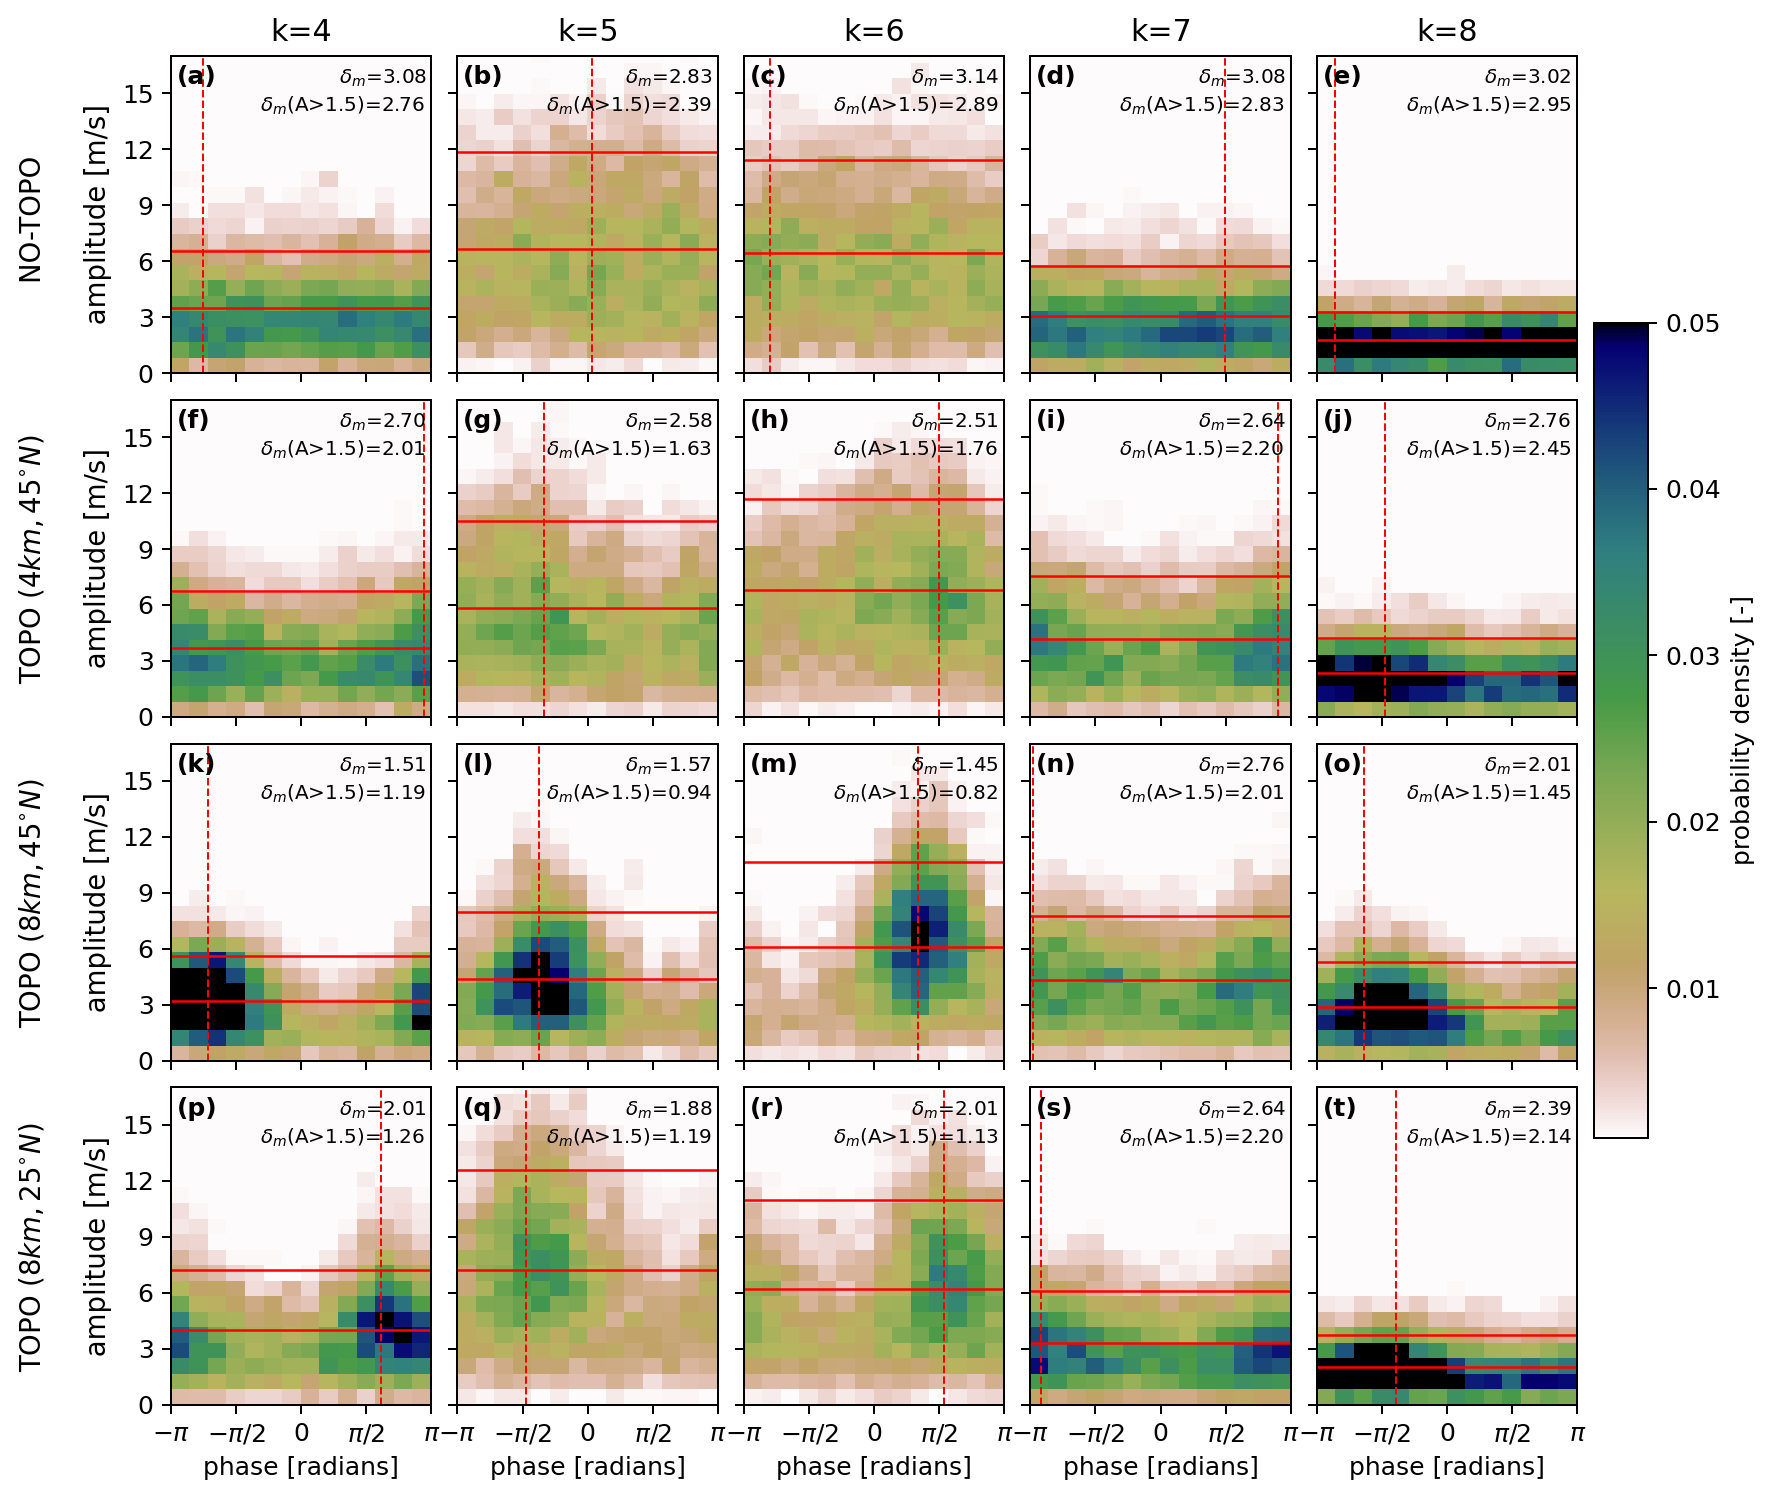

In [19]:
import cmaps
import string

plt.rcParams['figure.dpi'] = 180
mpl.rcParams['figure.figsize'] = 12,10

f, axes = plt.subplots(4,5, sharey= True, sharex=True)
axes = axes.flatten()

cmap=plt.cm.gist_earth_r

#y-labels
axes[0].set_ylabel('NO-TOPO \n\n amplitude [m/s] ', fontsize=11)
axes[5].set_ylabel('TOPO $(4km,45^{\circ} N)$ \n\n amplitude [m/s] ', fontsize=11)
axes[10].set_ylabel('TOPO $(8km,45^{\circ} N)$ \n\n amplitude [m/s] ', fontsize=11)
axes[15].set_ylabel('TOPO $(8km,25^{\circ} N)$ \n\n amplitude [m/s] ', fontsize=11)

#loop for each wavenumber and simulation
for i,k in enumerate([4,5,6,7,8]):
    for j in range(0,4):        
        if(j==0):
            axes[i].set_title('k='+str(k))
            
        hist,xedges,yedges,xcenters,ycenters=histogram_2d(phase_mnt[j,:,k],amp_mnt[j,:,k],15,25)
        X, Y = np.meshgrid(xedges, yedges)
        h = axes[j*5+i].pcolormesh(X, Y, hist.T, vmax=0.05,vmin=0.001, cmap=cmap)
        
        axes[j*5+i].axhline(amp_mnt[j].sel(wn=k).mean('time'), color='red',ls="-", lw=1.0)    
        axes[j*5+i].axhline(amp_mnt[j].sel(wn=k).mean('time')+1.5*amp_mnt[j].sel(wn=k).std('time'), color='red',ls="-", lw=1.0)
        
        axes[j*5+i].axvline(phase_max[j,i], color='red',ls="--", lw=0.8)

        axes[j*5+i].text(0.9, 15.5, r'$\delta_{m}$=%.2f' % delta_min[j,i], color='k', size=8)
        axes[j*5+i].text(-1.0, 14.0, r'$\delta_{m}$(A>1.5)=%.2f' % delta_min_highamp[j,i], color='k', size=8)
    
for ax in axes:
    ax.set_xlim([-np.pi, np.pi])
    ax.set_xticks(np.arange(-np.pi,np.pi+0.01,np.pi/2))
    ax.set_yticks(np.arange(0,16,3))    
    ax.set_ylim([0, 17])
    ax.set_aspect(0.45)
    
    
labels = ['$-\pi$','$-\pi/2$','0','$\pi/2$','$\pi$']
for i in range(15,20):
    axes[i].set_xticklabels(labels)
    axes[i].set_xlabel('phase [radians]', fontsize=10)
    
for i,ax in enumerate(axes):
    tx = ax.text(-3, 15.5, '(' + string.ascii_lowercase[i] + ')', color='k', size=10, weight='bold')

f.subplots_adjust(hspace=0.05, wspace=0.1)

# add common colorbar
cbar = plt.colorbar(h, ax=axes, label='probability density [-]',pad=0.01, orientation='vertical',shrink=0.6,aspect=15)

plt.savefig('figures/amplitude_phase_2dhist_ICON_hs_pannel_4sim_annotated_phaselocking_v300anomalies.pdf')